In [9]:
import numpy as np
import sys
from os import path
from scipy.stats import mode
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from bayes_opt import BayesianOptimization
from time import time
import seaborn as sns

sys.path.append(path.dirname(path.dirname(path.abspath("__file__"))))
from data.dataset import FaceData
from model.randomforest import RandomForest
from analysis.utils import get_avg_leaf_entropy

In [3]:
%load_ext autoreload
%autoreload 2

In [5]:
PATH = path.dirname(path.dirname(path.abspath("__file__"))) + "/data/face.mat"

data = FaceData(PATH)
train_X = data.train_X
train_y = data.train_y
test_X = data.test_X
test_y = data.test_y

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(416, 2576) (416,)
(104, 2576) (104,)


In [ ]:
"""
Avalilabel split mode
    1. axis-align
    2. two-pixel-test
"""

num_trees=20
depth=7
split_trial=1000
# split_mode="axis-align"
split_mode="two-pixel-test"

In [407]:
classifier = RandomForest(
    num_trees=num_trees,
    depth=depth,
    split_trial=split_trial,
    split_mode=split_mode,
    n_jobs=-1
)

In [408]:
classifier.train(train_X, train_y)

In [409]:
predict = classifier.predict(test_X)
accuracy = (predict == test_y).mean()
print(predict)
print(accuracy)

[ 1  1  2 18  3  3  4  4  5  5  6  6  7  7  8 45  9 14 10 10  6 17 12 12
 34 13 17 19  2 15  3 18  7  6 20  8 15 19 21 19 21 21 20 41 23 23  3 24
 25 25 23 12 27 48 28 28 14 23 27 30 31 31 32 32 15 33 34 52 40 40 36 36
 37 37 38 38 39 39 40 32 41 41 42 42 42 42 24  1 45 13 46 38 47 30 48 48
 36 11 39  5 51 51 52 21]
0.5769230769230769


Objective function for Bayesian Optimization

In [ ]:
TRAIN_PER_MODEL = 3
SPLIT_MODE_DIC = {
    0: "axis-align",
    1: "two-pixel-test"
}

def objective_fn(num_trees, depth, split_trial, split_mode):
    num_trees, depth, split_trial, split_mode = (int(k) for k in [num_trees, depth, split_trial, split_mode])

    mean_accuracy = 0
    for i in range(TRAIN_PER_MODEL):
        model = RandomForest(num_trees, depth, split_trial, SPLIT_MODE_DIC[split_mode], n_jobs=-2)
        model.train(train_X, train_y)
        predict = model.predict(test_X)
        accuracy = (predict == test_y).mean()
        mean_accuracy += accuracy
    mean_accuracy /= TRAIN_PER_MODEL

    return mean_accuracy

In [136]:
aa_pbounds = {
    'num_trees': (10, 31),
    'depth': (5, 9),
    'split_trial': (1, 2001),
    'split_mode': (0, 1)
}

tpt_pbounds = {
    'num_trees': (10, 31),
    'depth': (5, 9),
    'split_trial': (1, 2001),
    'split_mode': (1, 2)
}

aa_optimizer = BayesianOptimization(
    f=objective_fn,
    pbounds=aa_pbounds,
    verbose=2
)

tpt_optimizer = BayesianOptimization(
    f=objective_fn,
    pbounds=tpt_pbounds,
    verbose=2
)

In [131]:
def objective_fn2(split_trial):
    split_trial = int(split_trial)

    mean_accuracy = 0
    for i in range(TRAIN_PER_MODEL):
        model = RandomForest(30, 7, split_trial, SPLIT_MODE_DIC[0], n_jobs=-2)
        model.train(train_X, train_y)
        predict = model.predict(test_X)
        accuracy = (predict == test_y).mean()
        mean_accuracy += accuracy
    mean_accuracy /= TRAIN_PER_MODEL

    return mean_accuracy

In [137]:
aa_pbounds2 = {
    'split_trial': (1, 2001)
}

aa_optimizer2 = BayesianOptimization(
    f=objective_fn2,
    pbounds=aa_pbounds,
    verbose=2
)

Hyperparameter optimization for Axis-Align RandomForest

In [138]:
aa_optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   |   depth   | num_trees | split_... | split_... |
-------------------------------------------------------------------------
| 1         | 0.4327    | 6.9       | 14.76     | 0.7217    | 360.7     |
| 2         | 0.6635    | 8.502     | 18.55     | 0.1755    | 903.8     |
| 3         | 0.3782    | 5.004     | 23.45     | 0.9417    | 300.6     |
| 4         | 0.391     | 5.231     | 17.43     | 0.6449    | 1.995e+03 |
| 5         | 0.5609    | 6.617     | 20.33     | 0.2517    | 694.3     |
| 6         | 0.641     | 7.03      | 20.07     | 0.0645    | 897.6     |


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


| 7         | 0.4135    | 6.84      | 13.99     | 0.7629    | 964.2     |
| 8         | 0.6859    | 8.699     | 30.45     | 0.453     | 921.4     |
| 9         | 0.5128    | 6.505     | 18.46     | 0.001857  | 620.6     |
| 10        | 0.6827    | 7.683     | 29.35     | 0.9287    | 762.2     |
| 11        | 0.4135    | 6.811     | 10.29     | 0.706     | 798.6     |
| 12        | 0.7308    | 7.853     | 30.06     | 0.9873    | 736.6     |
| 13        | 0.4199    | 6.565     | 10.29     | 0.0762    | 741.1     |
| 14        | 0.4135    | 5.602     | 30.98     | 0.5384    | 748.6     |
| 15        | 0.6026    | 6.604     | 29.3      | 0.6066    | 732.3     |


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


| 16        | 0.5801    | 6.459     | 27.44     | 0.4138    | 739.5     |


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


| 17        | 0.7372    | 8.225     | 25.5      | 0.9125    | 921.6     |
| 18        | 0.5577    | 6.588     | 25.99     | 0.8098    | 916.9     |


KeyboardInterrupt: 

Best hyperparameter for Axis-Align
- depth: 7
- num_trees: 30
- num_trials: 933

In [13]:
for split_trial in [1, 500, 933, 1000, 1500, 2000]:
    print(objective_fn(30, 7, split_trial, 0))

0.16025641025641024
0.6826923076923076
0.7211538461538461
0.7051282051282052
0.6955128205128206
0.6762820512820514


Analyze different parameters

In [ ]:
def plot_graph(x, x_label, y, y_label, legend=None):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(x)
    plt.plot(x, y, 'r', label=legend, marker='o')
    plt.xlim(x[0]-0.2, x[-1]+0.2)
    # plt.legend()
    plt.show()


In [ ]:
# depth
l_depth = [5, 6, 7, 8, 97]
model_per_depth = {}

for depth in l_depth:
    print(f"Forest with depth {depth} growing..")
    model = RandomForest(30, depth, 933, SPLIT_MODE_DIC[0], -2)
    st_train = time()
    model.train(train_X, train_y)
    en_train = time()

    #accuracy
    st_pred = time()
    predict = model.predict(test_X)
    en_pred = time()

    #confusion mat and others
    conmat = confusion_matrix(test_y, predict)
    accuracy = accuracy_score(test_y, predict) * 100
    precision = precision_score(test_y, predict, average='macro') * 100
    recall = recall_score(test_y, predict, average='macro') * 100
    f1 = f1_score(test_y, predict, average='macro')

    #leaf entropy
    H_leaf = get_avg_leaf_entropy(model)

    #time efficiency
    train_time = en_train - st_train
    pred_time = en_pred - st_pred

    model_per_depth[str(depth)] = (
        model,
        accuracy,
        conmat,
        precision,
        recall,
        f1,
        H_leaf,
        train_time,
        pred_time
    )


[38.46153846153847, 62.5, 71.15384615384616, 69.23076923076923, 77.88461538461539, 74.03846153846155]


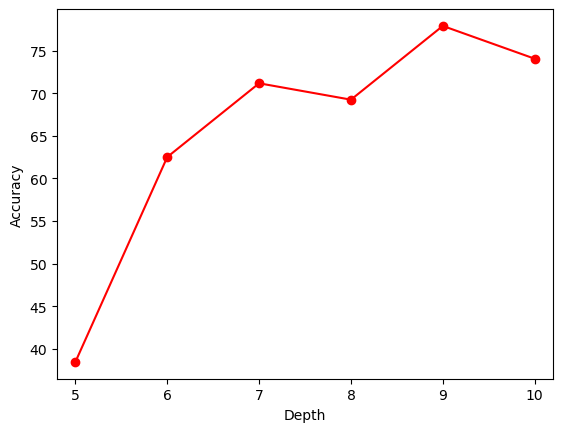

In [105]:
l_acc = [model_per_depth[str(depth)][1] for depth in l_depth]
print(l_acc)
plot_graph(l_depth, "Depth", l_acc, 'Accuracy')

[1.6428511087696493, 1.0003704494858288, 0.4832077893906329, 0.18692273539163748, 0.04291949754274786, 0.007429200327854704]


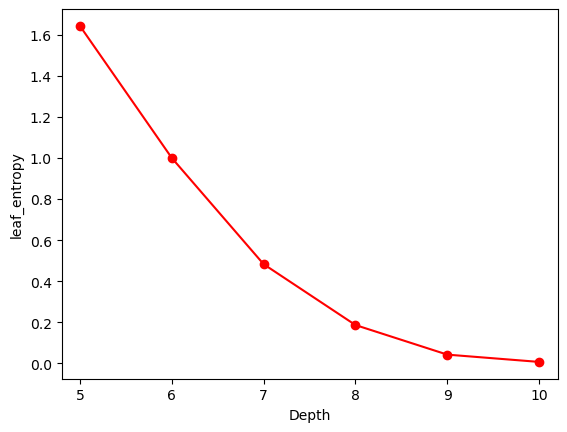

In [107]:
l_H = [model_per_depth[str(depth)][6] for depth in l_depth]
print(l_H)
plot_graph(l_depth, "Depth", l_H, "leaf_entropy")

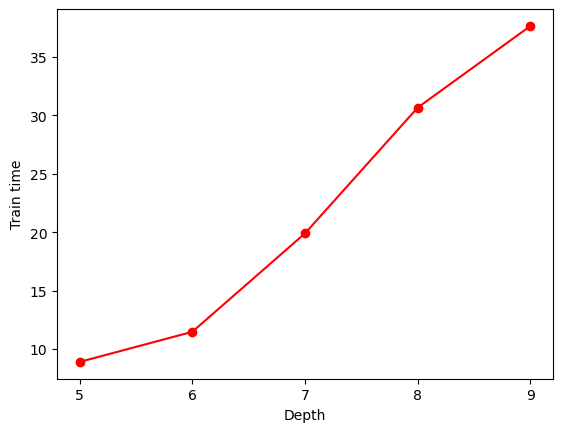

In [90]:
l_train_time = [model_per_depth[str(depth)][7] for depth in l_depth]
l_test_time = [model_per_depth[str(depth)][8] for depth in l_depth]
plot_graph(l_depth, "Depth", l_train_time, "Train time")

In [91]:
tpt_optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   |   depth   | num_trees | split_... | split_... |
-------------------------------------------------------------------------
| 1         | 0.4776    | 6.956     | 11.48     | 1.553     | 1.441e+03 |
| 2         | 0.3237    | 5.685     | 11.75     | 1.711     | 697.6     |
| 3         | 0.625     | 6.505     | 25.86     | 1.686     | 1.114e+03 |
| 4         | 0.4263    | 6.351     | 10.64     | 1.574     | 975.7     |
| 5         | 0.6378    | 7.074     | 23.27     | 1.382     | 226.0     |
| 6         | 0.4135    | 5.6       | 31.0      | 1.589     | 129.0     |
| 7         | 0.7179    | 7.194     | 24.19     | 1.403     | 1.296e+03 |
| 8         | 0.4006    | 5.222     | 23.02     | 1.766     | 449.7     |
| 9         | 0.4006    | 5.519     | 26.39     | 1.085     | 1.817e+03 |
| 10        | 0.6154    | 6.837     | 23.59     | 1.218     | 1.297e+03 |
| 11        | 0.7147    | 7.263     | 26.05     | 1.854     | 1.296e+03 |
| 12        | 0.4551    | 5.443     | 

In [99]:
# number of trees
l_N = [10, 20, 30, 40, 50, 60, 70]
model_per_N = {}

for N in l_N:
    print(f"Forest with N {N} growing..")
    model = RandomForest(N, 8, 933, SPLIT_MODE_DIC[0], -2)
    st_train = time()
    model.train(train_X, train_y)
    en_train = time()

    #accuracy
    st_pred = time()
    predict = model.predict(test_X)
    en_pred = time()

    #confusion mat and others
    conmat = confusion_matrix(test_y, predict)
    accuracy = accuracy_score(test_y, predict) * 100
    precision = precision_score(test_y, predict, average='macro') * 100
    recall = recall_score(test_y, predict, average='macro') * 100
    f1 = f1_score(test_y, predict, average='macro')

    #leaf entropy
    H_leaf = get_avg_leaf_entropy(model)

    #time efficiency
    train_time = en_train - st_train
    pred_time = en_pred - st_pred

    model_per_N[str(N)] = (
        model,
        accuracy,
        conmat,
        precision,
        recall,
        f1,
        H_leaf,
        train_time,
        pred_time
    )


Forest with N 10 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with N 20 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with N 30 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with N 40 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with N 50 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with N 60 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with N 70 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [102]:
l_acc = [model_per_N[str(N)][1] for N in l_N]
l_H = [model_per_N[str(N)][6] for N in l_N]
# l_acc = [model_per_N[str(N)][1] for N in l_N]
# l_acc = [model_per_N[str(N)][1] for N in l_N]
# plot_graph(l_N, "Depth", l_acc, 'Accuracy')
print(l_acc)
print(l_H)

[51.92307692307693, 63.46153846153846, 73.07692307692307, 79.8076923076923, 82.6923076923077, 78.84615384615384, 83.65384615384616]
[0.19037220217169556, 0.17690298353352027, 0.1776366224614645, 0.18223450989506335, 0.1846054395319777, 0.17921924009258017, 0.1777969608308449]


In [ ]:
# split_trial
l_trial = [1, 500, 933, 1000, 1500, 2000]
model_per_trial = {}

for t in l_trial:
    print(f"Forest with trial {t} growing..")
    model = RandomForest(30, 7, t, SPLIT_MODE_DIC[0], -2)
    st_train = time()
    model.train(train_X, train_y)
    en_train = time()

    #accuracy
    st_pred = time()
    predict = model.predict(test_X)
    en_pred = time()

    #confusion mat and others
    conmat = confusion_matrix(test_y, predict)
    accuracy = accuracy_score(test_y, predict) * 100
    precision = precision_score(test_y, predict, average='macro') * 100
    recall = recall_score(test_y, predict, average='macro') * 100
    f1 = f1_score(test_y, predict, average='macro')

    #leaf entropy
    H_leaf = get_avg_leaf_entropy(model)

    #time efficiency
    train_time = en_train - st_train
    pred_time = en_pred - st_pred

    model_per_trial[str(t)] = (
        model,
        accuracy,
        conmat,
        precision,
        recall,
        f1,
        H_leaf,
        train_time,
        pred_time
    )

Forest with trial 1 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with trial 500 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with trial 933 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with trial 1000 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with trial 1500 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Forest with trial 2000 growing..


/opt/homebrew/anaconda3/envs/cs485_cw/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [109]:
l_acc = [model_per_trial[str(t)][1] for t in l_trial]
l_H = [model_per_trial[str(t)][6] for t in l_trial]
print(l_acc)
print(l_H)

[19.230769230769234, 69.23076923076923, 71.15384615384616, 68.26923076923077, 65.38461538461539, 70.1923076923077]
[0.707829100201638, 0.5142757463128149, 0.49100490870634095, 0.4929772884720006, 0.478801659435206, 0.45880981565310464]


In [111]:
l_N = [10, 20, 30, 40, 50, 60, 70]
N_dict = {}

for N in tqdm(l_N):
    model = RandomForest(N, 7, 933, SPLIT_MODE_DIC[0], -2)

    accuracy, H_leaf = 0, 0
    for i in range(3):
        model.train(train_X, train_y)
        pred = model.predict(test_X)
        accuracy += accuracy_score(test_y, pred) * 100
        H_leaf += get_avg_leaf_entropy(model)
    accuracy /= 3
    H_leaf /= 3

    N_dict[str(N)] = (accuracy, H_leaf)

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [10:59<00:00, 94.21s/it] 


In [120]:
l_D = [5, 6, 7, 8, 9]
D_dict = {}

for D in tqdm(l_D):
    model = RandomForest(30, D, 933, SPLIT_MODE_DIC[0], -2)

    accuracy, H_leaf = 0, 0
    for i in range(3):
        model.train(train_X, train_y)
        pred = model.predict(test_X)
        accuracy += accuracy_score(test_y, pred) * 100
        H_leaf += get_avg_leaf_entropy(model)
    accuracy /= 3
    H_leaf /= 3

    D_dict[str(D)] = (accuracy, H_leaf)

100%|██████████| 5/5 [06:50<00:00, 82.20s/it] 


In [139]:
l_T = [1, 500, 933, 1000, 1500, 2000]
T_dict = {}

for T in tqdm(l_T):
    model = RandomForest(30, 7, T, SPLIT_MODE_DIC[0], -2)

    accuracy, H_leaf = 0, 0
    for i in range(3):
        model.train(train_X, train_y)
        pred = model.predict(test_X)
        accuracy += accuracy_score(test_y, pred) * 100
        H_leaf += get_avg_leaf_entropy(model)
    accuracy /= 3
    H_leaf /= 3

    T_dict[str(T)] = (accuracy, H_leaf)

100%|██████████| 6/6 [07:03<00:00, 70.58s/it]


In [119]:
l_acc = [N_dict[str(N)][0] for N in l_N]
l_H = [N_dict[str(N)][1] for N in l_N]
print(l_acc)
print(l_H)

[53.84615384615385, 60.57692307692307, 66.66666666666667, 73.3974358974359, 73.71794871794872, 75.64102564102564, 77.88461538461537]
[0.4790363917442247, 0.4905106798760888, 0.4948189690315444, 0.4865007048280983, 0.4885348293762492, 0.493245678088837, 0.48549303456203635]


In [123]:
l_acc = [D_dict[str(D)][0] for D in l_D]
l_H = [D_dict[str(D)][1] for D in l_D]
print(l_acc)
print(l_H)

[41.666666666666664, 58.65384615384615, 68.91025641025641, 73.07692307692308, 77.56410256410255]
[1.6599483066667986, 0.9987483873497222, 0.4965797312851607, 0.1797145520553369, 0.04572085014773791]


In [140]:
l_acc = [T_dict[str(T)][0] for T in l_T]
l_H = [T_dict[str(T)][1] for T in l_T]
print(l_acc)
print(l_H)

[14.423076923076922, 69.87179487179488, 72.43589743589743, 67.94871794871796, 70.51282051282051, 72.11538461538461]
[0.7626723540179569, 0.5262903956021204, 0.4873484751851735, 0.47664276780103876, 0.4683207892595835, 0.45496673019815664]


In [54]:
best_aa_model = RandomForest(30, 7, 933, 'axis-align', -2)
best_tpt_model = RandomForest(30, 7, 1292, 'two-pixel-test', -2)
best_aa_model.train(train_X, train_y)
best_tpt_model.train(train_X, train_y)

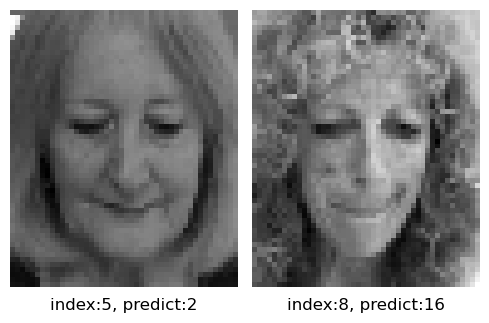

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 20))  # figsize 조정 (너비, 높이)

predict = best_aa_model.predict(test_X)
correct_list = test_X[predict==test_y][:5]
wrong_list = test_X[predict!=test_y][:2]

# 각 이미지 배열을 출력
for i, image_array in enumerate(wrong_list):

    image_array = image_array.reshape(46, 56).T
    axes[i].imshow(image_array, cmap='gray')  # numpy 배열을 i번째 subplot에 표시
    axes[i].axis('off')  # 축 숨기기
    axes[i].text(0.5, -0.04, f"index:{test_y[predict!=test_y][i]}, predict:{predict[predict!=test_y][i]}", ha='center', va='top', transform=axes[i].transAxes, fontsize=12)
    # axes[i].set_title(, fontsize=9, pad=10)
    

plt.tight_layout()  # 레이아웃 조정
plt.show()


TypeError: Cannot interpret '40' as a data type

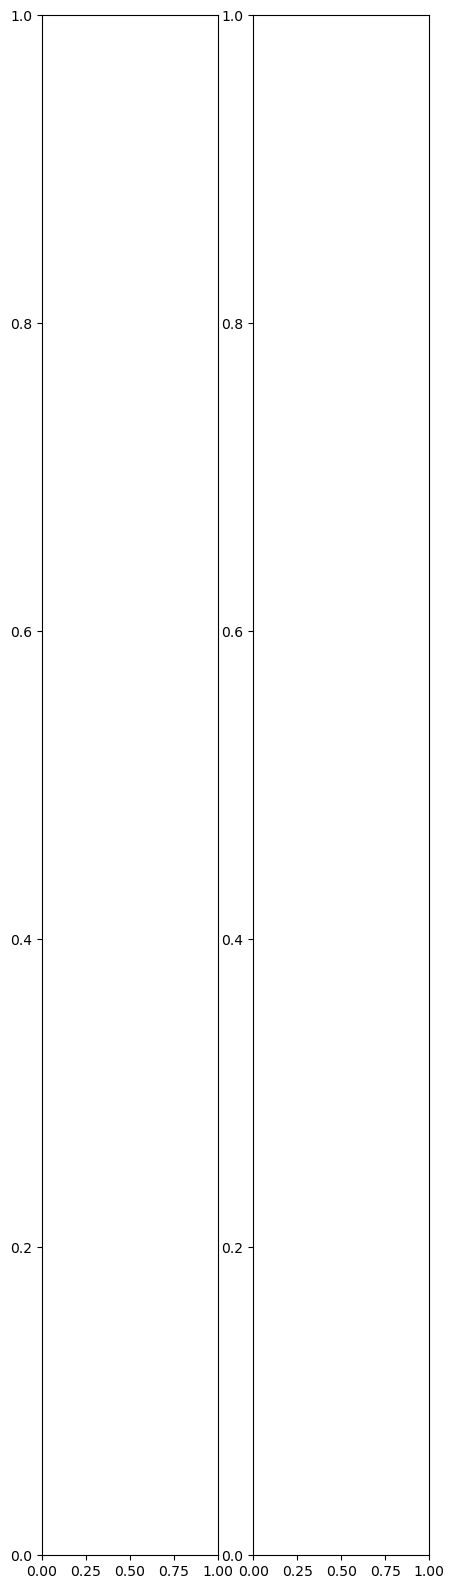

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(5, 20))  # figsize 조정 (너비, 높이)


rand = np.array([34, 40])
predict = best_tpt_model.predict(test_X)
correct_list = test_X[rand]

# 각 이미지 배열을 출력
for i, image_array in enumerate(correct_list):

    image_array = image_array.reshape(46, 56).T
    axes[i].imshow(image_array, cmap='gray')  # numpy 배열을 i번째 subplot에 표시
    axes[i].axis('off')  # 축 숨기기
    axes[i].text(0.5, -0.04, f"index:{test_y[predict==test_y][i*2]}, predict:{predict[predict==test_y][i*2]}", ha='center', va='top', transform=axes[i].transAxes, fontsize=12)
    # axes[i].set_title(, fontsize=9, pad=10)
    

plt.tight_layout()  # 레이아웃 조정
plt.show()


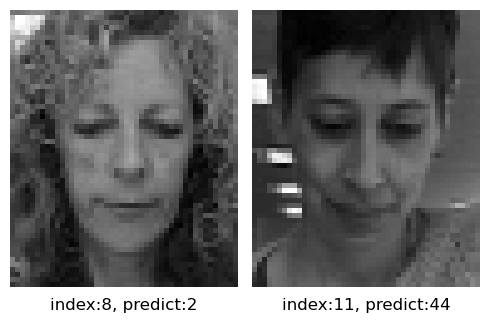

In [92]:
fig, axes = plt.subplots(1, 2, figsize=(5, 20))  # figsize 조정 (너비, 높이)

predict = best_tpt_model.predict(test_X)
correct_list = test_X[predict==test_y][:5]
wrong_list = test_X[predict!=test_y][:2]

# 각 이미지 배열을 출력
for i, image_array in enumerate(wrong_list):

    image_array = image_array.reshape(46, 56).T
    axes[i].imshow(image_array, cmap='gray')  # numpy 배열을 i번째 subplot에 표시
    axes[i].axis('off')  # 축 숨기기
    axes[i].text(0.5, -0.04, f"index:{test_y[predict!=test_y][i]}, predict:{predict[predict!=test_y][i]}", ha='center', va='top', transform=axes[i].transAxes, fontsize=12)
    # axes[i].set_title(, fontsize=9, pad=10)
    

plt.tight_layout()  # 레이아웃 조정
plt.show()


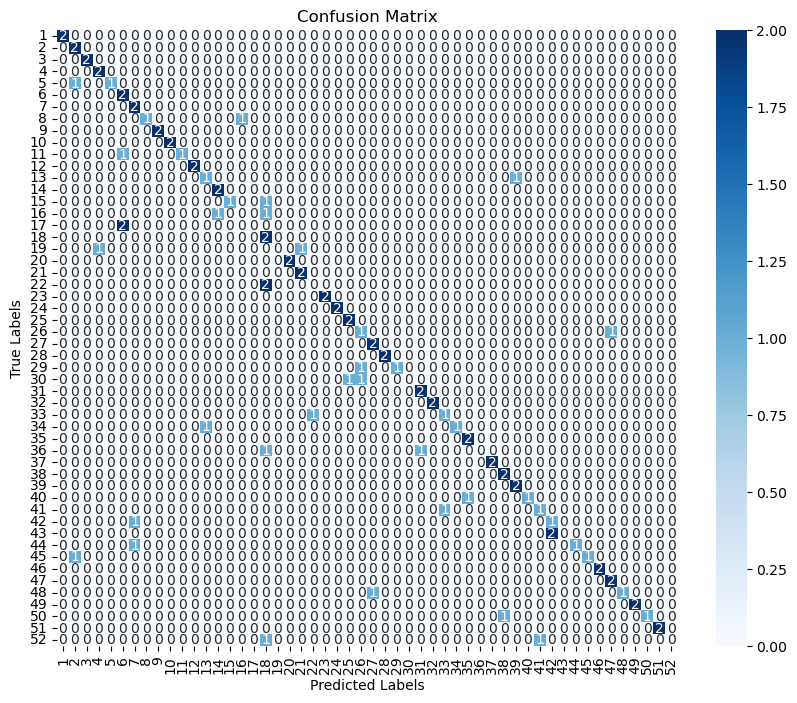

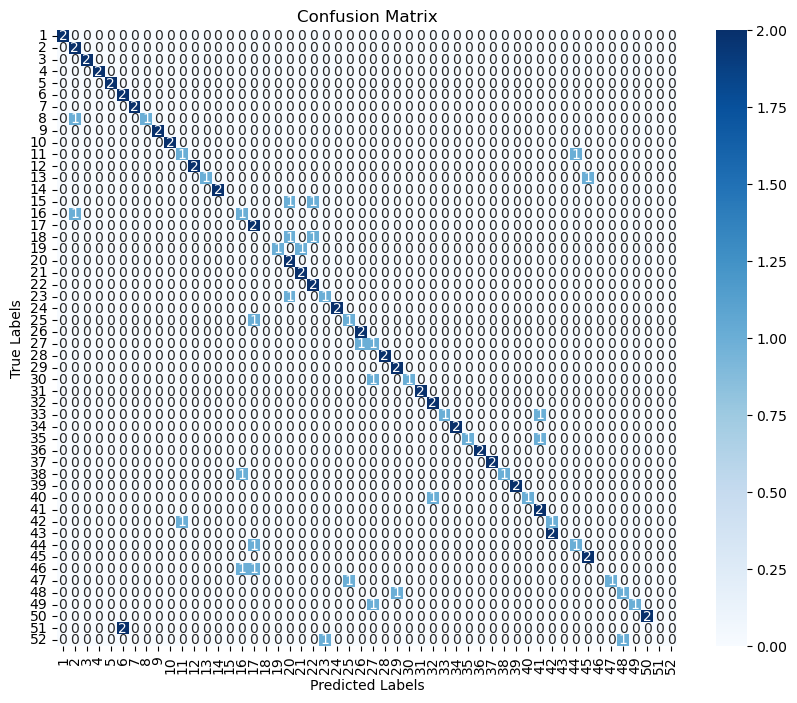

In [55]:
predict = best_aa_model.predict(test_X)
conmat = confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(conmat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_y), yticklabels=np.unique(test_y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
predict = best_tpt_model.predict(test_X)
conmat = confusion_matrix(test_y, predict)
plt.figure(figsize=(10, 8))
sns.heatmap(conmat, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_y), yticklabels=np.unique(test_y))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [21]:
from sklearn.decomposition import PCA

def apply_pca(X_train, X_test, n_components):
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    return X_train_pca, X_test_pca, pca

In [23]:
train_pca_X, test_pca_X, _ = apply_pca(train_X, test_X, 100)

In [42]:
pcarf_aa_model = RandomForest(30, 7, 993, 'axis-align', -2)

In [43]:
pcarf_aa_model.train(train_pca_X, train_y)
predict = pcarf_aa_model.predict(test_pca_X)
accuracy = accuracy_score(test_y, predict) * 100
print(accuracy)

46.15384615384615


In [40]:
print(test_X.shape)
print(test_pca_X.shape)
print(test_y.shape)

(104, 2576)
(104, 100)
(104,)


In [46]:
SPLIT_MODE_DIC = {
    0: "axis-align",
    1: "two-pixel-test"
}

l_N = [10, 20, 30, 40, 50, 60, 70]
l_D = [5, 6, 7, 8, 9]
l_T = [1, 500, 933, 1000, 1500, 2000]

In [48]:
N_times = []
for N in tqdm(l_N):
    model = RandomForest(N, 7, 933, SPLIT_MODE_DIC[0], -2)
    st_train = time()
    model.train(train_X, train_y)
    en_train = time()
    pred = model.predict(test_X)
    en_pred = time()
    
    N_times.append((en_train-st_train, en_pred-en_train))

100%|██████████| 7/7 [03:47<00:00, 32.55s/it]


In [49]:
D_times = []
for D in tqdm(l_D):
    model = RandomForest(30, D, 933, SPLIT_MODE_DIC[0], -2)
    st_train = time()
    model.train(train_X, train_y)
    en_train = time()
    pred = model.predict(test_X)
    en_pred = time()
    
    D_times.append((en_train-st_train, en_pred-en_train))

100%|██████████| 5/5 [02:21<00:00, 28.26s/it]


In [50]:
T_times = []
for T in tqdm(l_T):
    model = RandomForest(30, 7, T, SPLIT_MODE_DIC[0], -2)
    st_train = time()
    model.train(train_X, train_y)
    en_train = time()
    pred = model.predict(test_X)
    en_pred = time()
    
    T_times.append((en_train-st_train, en_pred-en_train))

100%|██████████| 6/6 [03:01<00:00, 30.23s/it]


In [51]:
print(N_times)

[(7.074749946594238, 0.3010740280151367), (12.989816904067993, 0.4893920421600342), (23.091115951538086, 0.6531531810760498), (29.893229961395264, 0.8873531818389893), (40.00224304199219, 0.9452419281005859), (50.581127882003784, 1.1944923400878906), (58.33413600921631, 1.2780711650848389)]


In [52]:
print(D_times)

[(10.054031133651733, 0.5390777587890625), (16.837304830551147, 0.6015880107879639), (27.05461597442627, 0.6844351291656494), (39.14541578292847, 0.7456231117248535), (44.74200081825256, 0.8154580593109131)]


In [53]:
print(T_times)

[(0.5246808528900146, 0.6671440601348877), (15.422240018844604, 0.6986539363861084), (26.983590126037598, 0.7286217212677002), (29.747865200042725, 0.6942739486694336), (47.615986347198486, 0.7018587589263916), (56.82879900932312, 0.6601481437683105)]


In [59]:
n_jobs_list = [1, 2, 4, 8]
job_times = []
for n_jobs in tqdm(n_jobs_list):
    model = RandomForest(30, 7, 933, SPLIT_MODE_DIC[0], n_jobs)
    st_train = time()
    model.train(train_X, train_y)
    en_train = time()
    pred = model.predict(test_X)
    en_pred = time()
    job_times.append((en_train-st_train, en_pred-en_train))

print(job_times)

100%|██████████| 4/4 [02:34<00:00, 38.63s/it]

[(64.80417585372925, 0.17349815368652344), (36.10434412956238, 0.5924210548400879), (26.692556142807007, 0.6112067699432373), (24.82064390182495, 0.690521240234375)]


In [57]:
print(job_times)

[(63.380903005599976, 0.18052983283996582), (21.886544942855835, 0.6072649955749512), (20.48389506340027, 0.6530680656433105)]


In [60]:
def pcarf_objective_fn(split_trial, m_pca):
    split_trial, m_pca = int(split_trial), int(m_pca)

    mean_accuracy = 0
    pca = PCA(n_components=m_pca)
    X_train_pca = pca.fit_transform(train_X)
    X_test_pca = pca.transform(test_X)
    
    for i in range(3):
        model = RandomForest(30, 7, split_trial, SPLIT_MODE_DIC[1], n_jobs=-2)
        model.train(X_train_pca, train_y)
        predict = model.predict(X_test_pca)
        accuracy = (predict == test_y).mean()
        mean_accuracy += accuracy
    mean_accuracy /= 3

    return mean_accuracy

In [65]:
pcarf_pbounds = {
    'split_trial': (300, 2001),
    'm_pca': (30, 120)
}

pcarf_optimizer = BayesianOptimization(
    f=pcarf_objective_fn,
    pbounds=pcarf_pbounds,
    verbose=2
)

In [66]:
pcarf_optimizer.maximize(init_points=10, n_iter=30)

|   iter    |  target   |   m_pca   | split_... |
-------------------------------------------------
| 1         | 0.5       | 51.24     | 980.2     |
| 2         | 0.4583    | 115.7     | 1.631e+03 |
| 3         | 0.5417    | 32.11     | 910.5     |
| 4         | 0.4808    | 74.83     | 1.232e+03 |
| 5         | 0.4872    | 69.02     | 354.3     |
| 6         | 0.4615    | 74.45     | 329.6     |
| 7         | 0.4904    | 91.0      | 1.437e+03 |
| 8         | 0.484     | 110.4     | 1.205e+03 |
| 9         | 0.5192    | 69.6      | 1.496e+03 |
| 10        | 0.5385    | 30.33     | 1.79e+03  |
| 11        | 0.5449    | 34.56     | 910.1     |
| 12        | 0.5096    | 63.22     | 888.6     |
| 13        | 0.5256    | 51.1      | 929.7     |
| 14        | 0.5128    | 37.59     | 1.82e+03  |
| 15        | 0.5481    | 43.09     | 1.763e+03 |
| 16        | 0.4679    | 66.52     | 1.781e+03 |
| 17        | 0.5385    | 33.37     | 1.749e+03 |
| 18        | 0.5032    | 31.35     | 889.2     |


In [93]:
pca = PCA(n_components=221)
X_train_pca = pca.fit_transform(train_X)
X_test_pca = pca.transform(test_X)
accuracy = 0

for i in range(3):
    model = RandomForest(30, 7, 1528, SPLIT_MODE_DIC[1], n_jobs=-2)
    model.train(X_train_pca, train_y)
    predict = model.predict(X_test_pca)
    accuracy += (predict==test_y).mean()
accuracy /= 3
print(accuracy)

0.4166666666666667
